### Importing necessary libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


### Loading already prepared corpus from google drive.

In [2]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fine_Food_Review/corpus1.csv")
df1k = df.loc[0:99999,:]
print("Shape of the dataframe to be worked on:- ",df1k.shape)
print(df1k['Score'].value_counts())
df1k.head(5)

Shape of the dataframe to be worked on:-  (100000, 3)
1    87729
0    12271
Name: Score, dtype: int64


,Text,Time,Score
0,witti littl book make son laugh loud recit car...,939340800,1
1,rememb see show air televis year ago child sis...,940809600,1
2,beetlejuic well written movi everyth excel act...,944092800,1
3,twist rumplestiskin captur film star michael k...,944438400,1
4,beetlejuic excel funni movi keaton hilari wack...,946857600,1


### Time based splitting into train and test data

In [0]:
#Time based splitting into train and test data
from sklearn.model_selection import TimeSeriesSplit
def timesplit(x,y):
    ts = TimeSeriesSplit(n_splits = 4)
    for train_index,test_index in ts.split(x):
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y[train_index],y[test_index]
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = timesplit(df1k["Text"].values,df1k["Score"].values)

### Preprocessing the text data

In [5]:
from keras.preprocessing.text import Tokenizer
top_words = 20000
t = Tokenizer(num_words=top_words)
t.fit_on_texts(x_train)
print("Vocabulary size:- ",len(t.word_counts))
train_seq = t.texts_to_sequences(x_train)
test_seq = t.texts_to_sequences(x_test)

#Padding
max_review_length = 256
x_train = sequence.pad_sequences(train_seq, maxlen=max_review_length)
x_test = sequence.pad_sequences(test_seq, maxlen=max_review_length)
print("Shape of the sequences after padding:- ",x_train.shape)

Vocabulary size:-  34244
Shape of the sequences after padding:-  (80000, 256)


In [6]:
print(train_seq[1])
print(x_train[1])

[494, 154, 731, 980, 5884, 41, 299, 850, 1110, 571, 70, 11802, 47, 3164, 117, 10, 2981, 886, 3602, 4155, 2013, 3107, 4558, 3602, 312, 115, 867, 75, 3900, 522, 886, 655, 3602, 610, 260]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0

### Model 1: 1 layer of 15 LSTMs

In [16]:
embedding_vecor_length = 16
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.3))
model.add(LSTM(15))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 256, 16)           320000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256, 16)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 15)                1920      
_________________________________________________________________
dropout_6 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 321,936
Trainable params: 321,936
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
#Calculating class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([4.16970708, 0.56812533])

In [17]:
#Compiling and Fitting the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
res = model.fit(x_train, y_train, epochs=10, batch_size=512, validation_data = (x_test,y_test),class_weight={0:4.16,1:0.57})

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 70s 872us/step - loss: 0.5644 - acc: 0.8189 - val_loss: 0.3767 - val_acc: 0.8337
Epoch 2/10
80000/80000 [==============================] - 69s 865us/step - loss: 0.3267 - acc: 0.8674 - val_loss: 0.3262 - val_acc: 0.8651
Epoch 3/10
80000/80000 [==============================] - 68s 856us/step - loss: 0.2731 - acc: 0.8916 - val_loss: 0.2849 - val_acc: 0.8812
Epoch 4/10
80000/80000 [==============================] - 69s 864us/step - loss: 0.2449 - acc: 0.9042 - val_loss: 0.2966 - val_acc: 0.8798
Epoch 5/10
80000/80000 [==============================] - 68s 854us/step - loss: 0.2288 - acc: 0.9102 - val_loss: 0.3016 - val_acc: 0.8829
Epoch 6/10
80000/80000 [==============================] - 69s 858us/step - loss: 0.2114 - acc: 0.9162 - val_loss: 0.3370 - val_acc: 0.8730
Epoch 7/10
80000/80000 [==============================] - 69s 860us/step - loss: 0.2008 - acc: 0.9192 - val_loss: 0.

In [0]:
#Function to plot train and test loss
import matplotlib.pyplot as plt
import seaborn as sns
def plt_dynamic(x, vy, ty):
    sns.set_style('whitegrid')
    plt.plot(x, vl, 'r', label="Validation Loss")
    plt.plot(x, tl, 'b', label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.legend()
    plt.show()

Test loss: 0.2970479115128517
Test accuracy: 0.8898


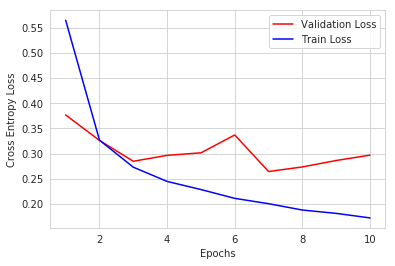

In [19]:
#Training and test loss vs n_epoch graph
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

# list of epoch numbers
x = list(range(1,11))

vl = res.history['val_loss']
tl = res.history['loss']
plt_dynamic(x, vl, tl)

Model 2: 1 layer 0f 16 LSTMs and 2nd layer of 8 LSTMs

In [26]:
embedding_vecor_length = 16
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(16,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(8))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 256, 16)           320000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 256, 16)           2112      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256, 16)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dropout_12 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 322,921
Trainable params: 322,921
Non-trainable params: 0
_________________________________________________________________
None

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
res = model.fit(x_train, y_train, epochs=10, batch_size=512,validation_data = (x_test,y_test),class_weight={0:4.16,1:0.57})

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 137s 2ms/step - loss: 0.5249 - acc: 0.7743 - val_loss: 0.3707 - val_acc: 0.8524
Epoch 2/10
80000/80000 [==============================] - 133s 2ms/step - loss: 0.3428 - acc: 0.8805 - val_loss: 0.3161 - val_acc: 0.8780
Epoch 3/10
80000/80000 [==============================] - 134s 2ms/step - loss: 0.2920 - acc: 0.8992 - val_loss: 0.3145 - val_acc: 0.8759
Epoch 4/10
80000/80000 [==============================] - 134s 2ms/step - loss: 0.2608 - acc: 0.9105 - val_loss: 0.2904 - val_acc: 0.8874
Epoch 5/10
80000/80000 [==============================] - 133s 2ms/step - loss: 0.2419 - acc: 0.9169 - val_loss: 0.3275 - val_acc: 0.8700
Epoch 6/10
80000/80000 [==============================] - 134s 2ms/step - loss: 0.2220 - acc: 0.9204 - val_loss: 0.3249 - val_acc: 0.8752
Epoch 7/10
80000/80000 [==============================] - 134s 2ms/step - loss: 0.2083 - acc: 0.9263 - val_loss: 0.2935 - 

Test loss: 0.3278408561855555
Test accuracy: 0.88885


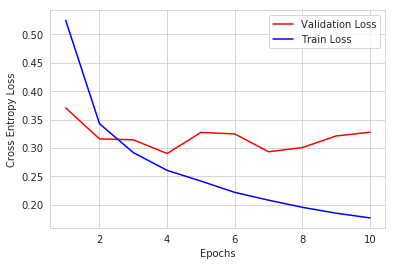

In [28]:
#Training and test loss vs n_epoch graph
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

# list of epoch numbers
x = list(range(1,11))

vl = res.history['val_loss']
tl = res.history['loss']
plt_dynamic(x, vl, tl)

### Conclusion

| Architecture | Training Loss | Train Accuracy | Test loss | Test Accuracy |
| - | - | - | - | - |
| 1 LSTM layer | 0.1726 | 93.15 | 0.2970 | 88.98 |
| 2 LSTM layers | 0.1771 | 93.63 | 0.3278 | 88.89 |